In [1]:
from SPCE_optuna import  *
from SPCE_postprocess import *

from UQpy.sampling import LatinHypercubeSampling
from UQpy.sampling.stratified_sampling.latin_hypercube_criteria import *

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mycolorpy import colorlist as mcp

from scipy.stats import norm

import proplot as pplt

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]



In [2]:
if not os.path.exists("plots/SPCE_verification"):
    os.makedirs("plots/SPCE_verification")

# 1. Geometric Brownian motion

In [3]:
# we can sample directly from analytic: sample_analytic_GBM()

def GBM(X, S0=1, T=1, n_steps=100, n_model_runs=400, verbose=False):
    x1 = X[0]
    x2 = X[1]
    
    dt = T/n_steps
    
    # simulation
    St = np.exp(
        (x1 - x2 ** 2 / 2) * dt + x2 * 
        np.random.normal(0, np.sqrt(dt), size=(n_model_runs,n_steps)).T
    )
   
    St = np.vstack([np.ones(n_model_runs), St])
    # the cumulative product of elements along simulation paths
    St = S0 * St.cumprod(axis=0)
    
    if verbose:
        time = np.linspace(0,T,n+1)
        tt = np.full(shape=(n_model_runs,n+1), fill_value=time).T
        
        plt.plot(tt, St)
        plt.xlabel("Years $t$")
        plt.ylabel("Stock Price $S_t$")
        plt.title(
            "Realizations of Geometric Brownian Motion\n \
            $dS_t = S_tx_1 dt + S_tx_2dW_t$\n $S_0 = {0}, \
            x_1 = {1}, x_2 = {2}$".format(S0, x1, x2)
        )
        plt.show()
    
    return St[-1]


S1 = GBM([0.07, 0.13], n_model_runs=10000)

def pdf_analytic_GBM(X, x_pts):
    
    x1 = X[0]
    x2 = X[1]
    
    mu = x1 - x2**2/2
    sigma = x2 
        
    pdf = (np.exp(-(np.log(x_pts) - mu)**2 / (2 * sigma**2))
           / (x_pts * sigma * np.sqrt(2 * np.pi)))
    
    return pdf
    
    
def sample_analytic_GBM(X, n_samples):
    
    x1 = X[0]
    x2 = X[1]
    
    mu = x1 - x2**2/2
    sigma = x2 
    
    s = np.random.lognormal(mu, sigma, n_samples)
    
    return s

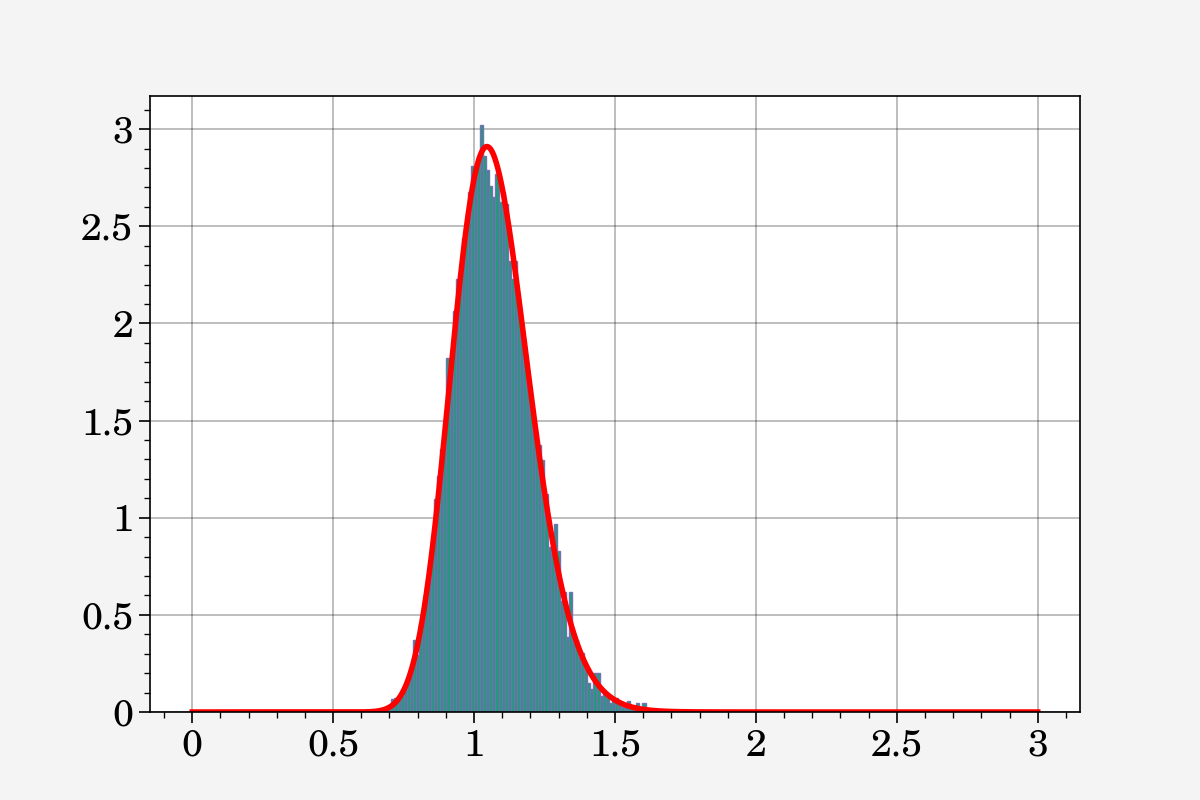

In [4]:
x = np.linspace(0, 3, 10000)
pdf = pdf_analytic_GBM([0.07, 0.13], x)

plt.plot(x, pdf, linewidth=2, color='red')
plt.hist(S1, bins=100, density=True, facecolor='#1b9e77', 
             edgecolor='#7570b3', linewidth=0.5)
plt.axis('tight')
plt.show()

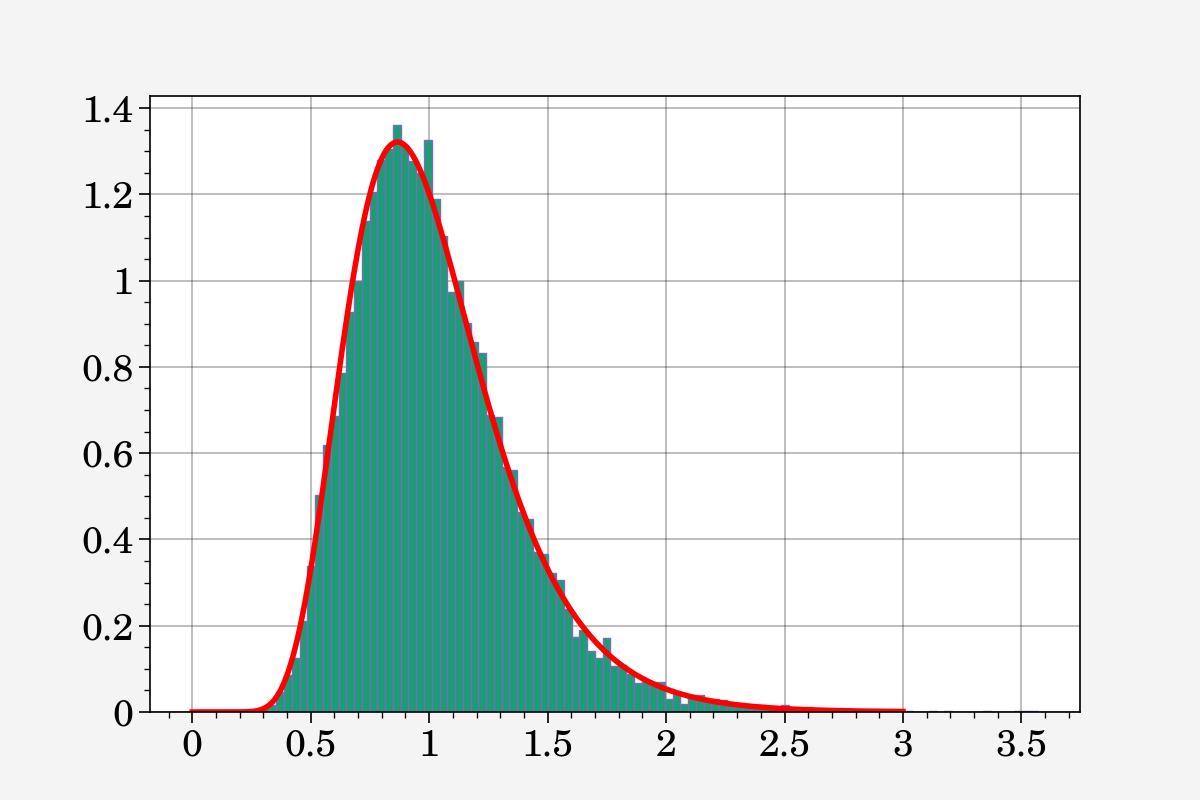

In [5]:
X = [0.02, 0.33]

s = sample_analytic_GBM(X, n_samples=10000)

x_pts = np.linspace(0, 3, 10000)
pdf = pdf_analytic_GBM(X, x_pts)

plt.plot(x, pdf, linewidth=2, color='r')
plt.hist(s, bins=100, density=True, facecolor='#1b9e77', 
             edgecolor='#7570b3', linewidth=0.5)
plt.axis('tight')
plt.show()

In [6]:
n_samples = 400

# Probability distributions of input parameters
pdf1 = Uniform(loc=0., scale=0.1)  # x1
pdf2 = Uniform(loc=0.1, scale=0.3)  # x2

margs = [pdf1, pdf2]
joint_x = JointIndependent(marginals=margs)

lhs_random = LatinHypercubeSampling(distributions=margs, nsamples=n_samples,
                                    criterion=Random())

X = lhs_random._samples

out = []

for i in range(X.shape[0]):
    out_ = sample_analytic_GBM(X[i], n_samples=1)
    out.append(out_)

y = np.array(out)

In [7]:
sim_name = "GBM_U_N_p3_p5"

if not os.path.exists(f"optuna_verbose/{sim_name}"):

    SPCE_result_optuna = StochasticPCE(X = X, 
                                       y = y, 
                                       dist_obj = joint_x,
                                       D = ["Uniform", "Normal"], 
                                       p_values = [3, 4, 5],
                                       q_values = [0.5, 0.75, 1],
                                       scale_e_LOO = 1,
                                       sim_name = sim_name).fit_adaptively()


`GBM_U_N_p3_p`

best CV score: Normal, $p=3, q=1$

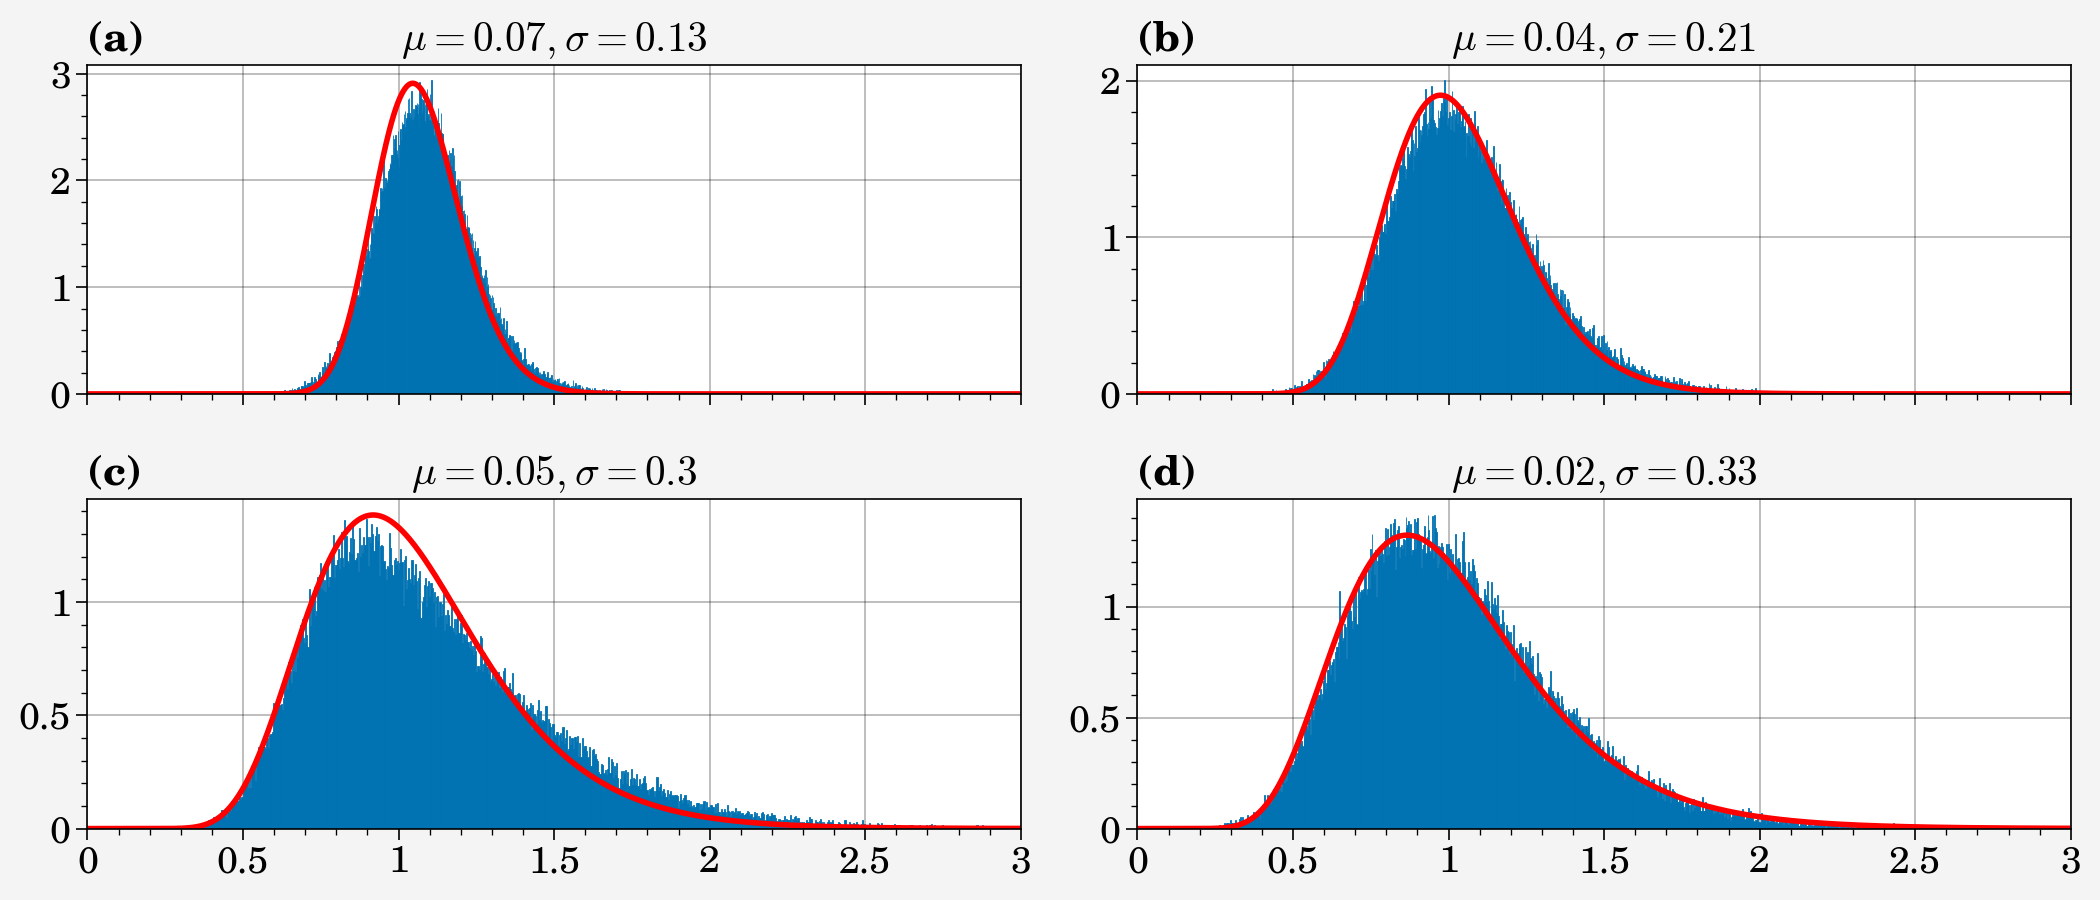

In [8]:
SPCE_results = np.load(f'optuna_verbose/GBM_U_N_p3_p5/inter_res_D_Normal_p_3_q_1.npz', 
                      allow_pickle=True)

D     = SPCE_results['x1']
p     = SPCE_results['x2']
q     = SPCE_results['x3']
A     = SPCE_results['x4']
c_hat = SPCE_results['x5']
sigma_hat = SPCE_results['x6']
cv_score  = SPCE_results['x7']


x_samples = [[0.07, 0.13], [0.04, 0.21], 
             [0.05, 0.3], [0.02, 0.33]]

x_sample_titles = [r"$\mu = 0.07, \sigma = 0.13$",
                   r"$\mu = 0.04, \sigma = 0.21$",
                   r"$\mu = 0.05, \sigma = 0.3$",
                   r"$\mu = 0.02, \sigma = 0.33$",
                  ]


fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(10.5, 4.5), sharex=True, sharey=False)

for i, x_sample in enumerate(x_samples):
    check = sample_from_cond_pdf(x = x_sample, 
                                 n_samples = 100000, 
                                 c = c_hat, 
                                 sigma = sigma_hat, 
                                 D = D, 
                                 A = A,  
                                 dist_obj = joint_x)


    x = np.linspace(0, 3, 10000)
    pdf = pdf_analytic_GBM(x_sample, x)

    axs[i].plot(x, pdf, linewidth=2, color='r')
    axs[i].hist(check, bins=1000, density=True)
    
    axs[i].format(title=x_sample_titles[i])
    
    
for ax in axs:
    ax.format(abc='(a)', xlim=(0, 3))

plt.show()

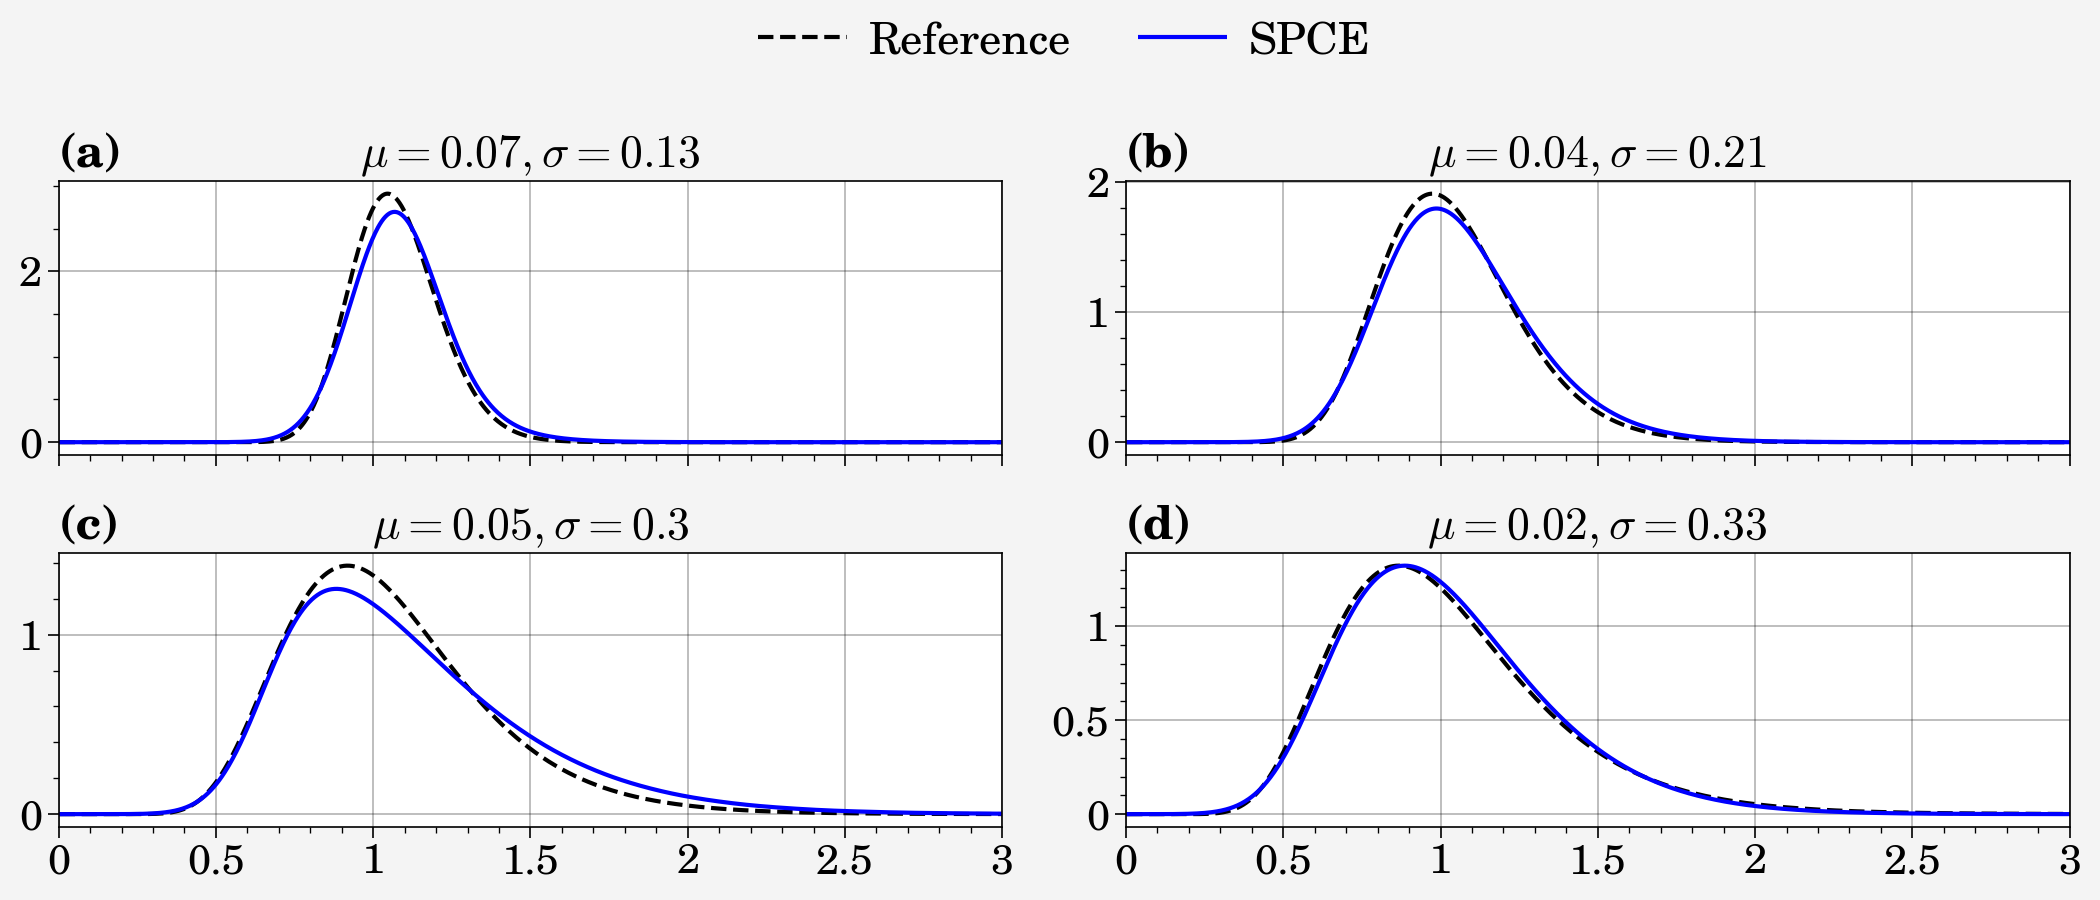

In [9]:
y_pts = np.linspace(0, 3, 1000)

x_samples = [[0.07, 0.13], [0.04, 0.21], 
             [0.05, 0.3], [0.02, 0.33]]

x_sample_titles = [r"$\mu = 0.07, \sigma = 0.13$",
                   r"$\mu = 0.04, \sigma = 0.21$",
                   r"$\mu = 0.05, \sigma = 0.3$",
                   r"$\mu = 0.02, \sigma = 0.33$",
                  ]


fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(10.5, 4.5), sharex=True, sharey=False)

for i, x_sample in enumerate(x_samples):
    est_pdf = explicit_pdf(y_pts=y_pts, 
                           x = x_sample, 
                           c = c_hat, 
                           sigma = sigma_hat, 
                           D = D, 
                           A = A,  
                           dist_obj = joint_x,
                           NQ=100)


    x = np.linspace(0, 3, 10000)
    pdf = pdf_analytic_GBM(x_sample, x)

    axs[i].plot(y_pts, pdf_analytic_GBM(x_sample, y_pts), label = "Reference", 
                linewidth=1.5, color='k', ls="--")
    axs[i].plot(y_pts, est_pdf, linewidth=1.5, color='b', label = "SPCE")
    
    axs[i].format(title=x_sample_titles[i], fontsize = 15)

fig.legend(["Reference", "SPCE"], ncols=2, frame=False, loc='t',
           fontsize = 16, bbox_to_anchor=(0.5, 0.8))
       
for ax in axs:
    ax.format(abc='(a)', xlim=(0, 3))

plt.tight_layout()
plt.savefig("plots/SPCE_verification/GBM_PDFs.pdf", bbox_inches="tight")
plt.show()

# Bimodal analytical example

In [10]:
def mixture_gaussian_example(x, y):
    
    phi = norm

    gaussian_1 = 0.5  * phi.pdf(1.25 * y - (5 * np.sin(np.pi * x) ** 2 + (5 * x) - 2.5))
    gaussian_2 = 0.75 * phi.pdf(1.25 * y - (5 * np.sin(np.pi * x) ** 2 - (5 * x) + 2.5))

    mixture_gaussian = gaussian_1+gaussian_2
    
    return mixture_gaussian


def sample_mixture_gaussian(x, y, n_samples):
    
    pdf = mixture_gaussian_example(x, y)
    
    s = np.random.choice(y, size=n_samples, p=pdf/np.sum(pdf))
    
    return s



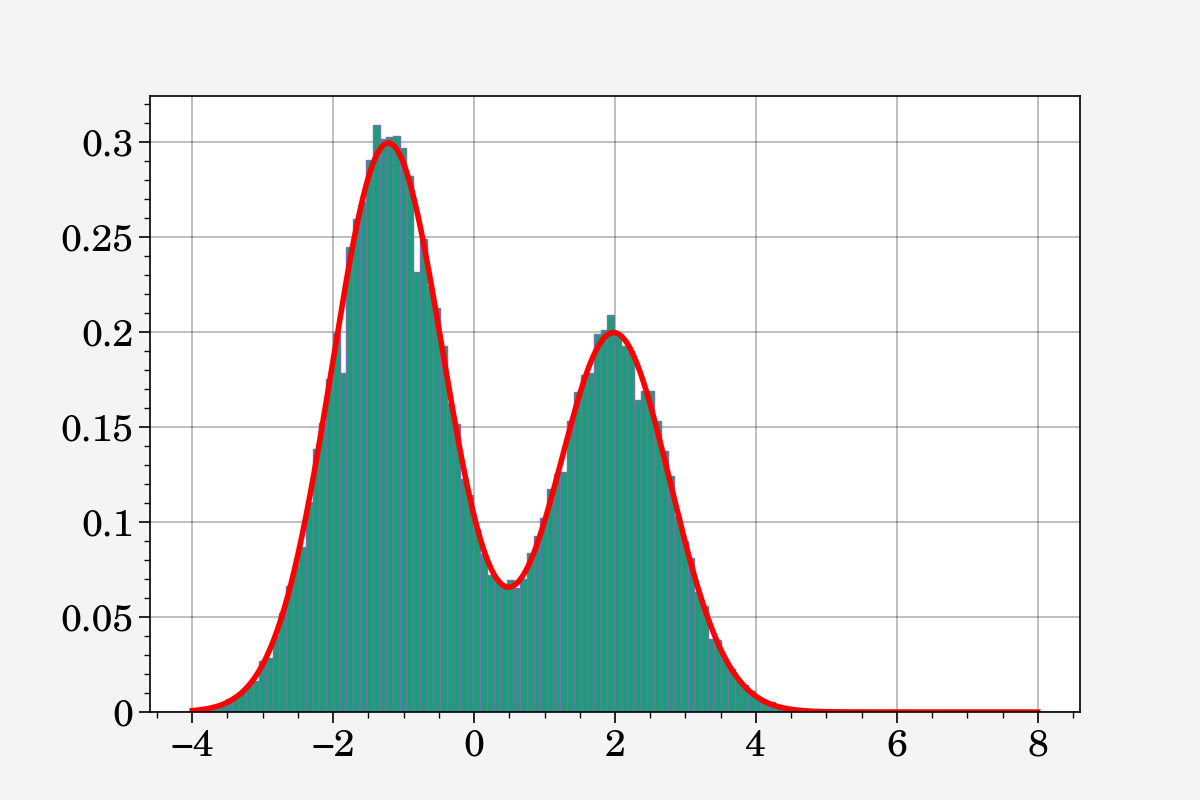

In [11]:
x_sample = 0.9
y_pts = np.linspace(-4, 8, 1000)

plt.hist(sample_mixture_gaussian(x_sample, y_pts, 100000), bins=100, density=True,
         facecolor='#1b9e77', edgecolor='#7570b3', linewidth=0.5)
plt.plot(y_pts, mixture_gaussian_example(x_sample, y_pts), linewidth=2, color='r')
plt.show()

In [12]:
n_samples = 800

# Probability distributions of input parameters
pdfX = Uniform(loc=0.0, scale=1.0)

margs = [pdfX]
joint_x = JointIndependent(marginals=margs)

lhs_random = LatinHypercubeSampling(distributions=margs, nsamples=n_samples,
                                    criterion=Random())
X = lhs_random._samples
# X = pdfX.rvs(n_samples)

y_pts = np.linspace(-4, 8, 1000)

out = []

for i in range(X.shape[0]):
    
    out_ = sample_mixture_gaussian(X[i], y_pts, n_samples=1)
    out.append(out_)

y = np.array(out)


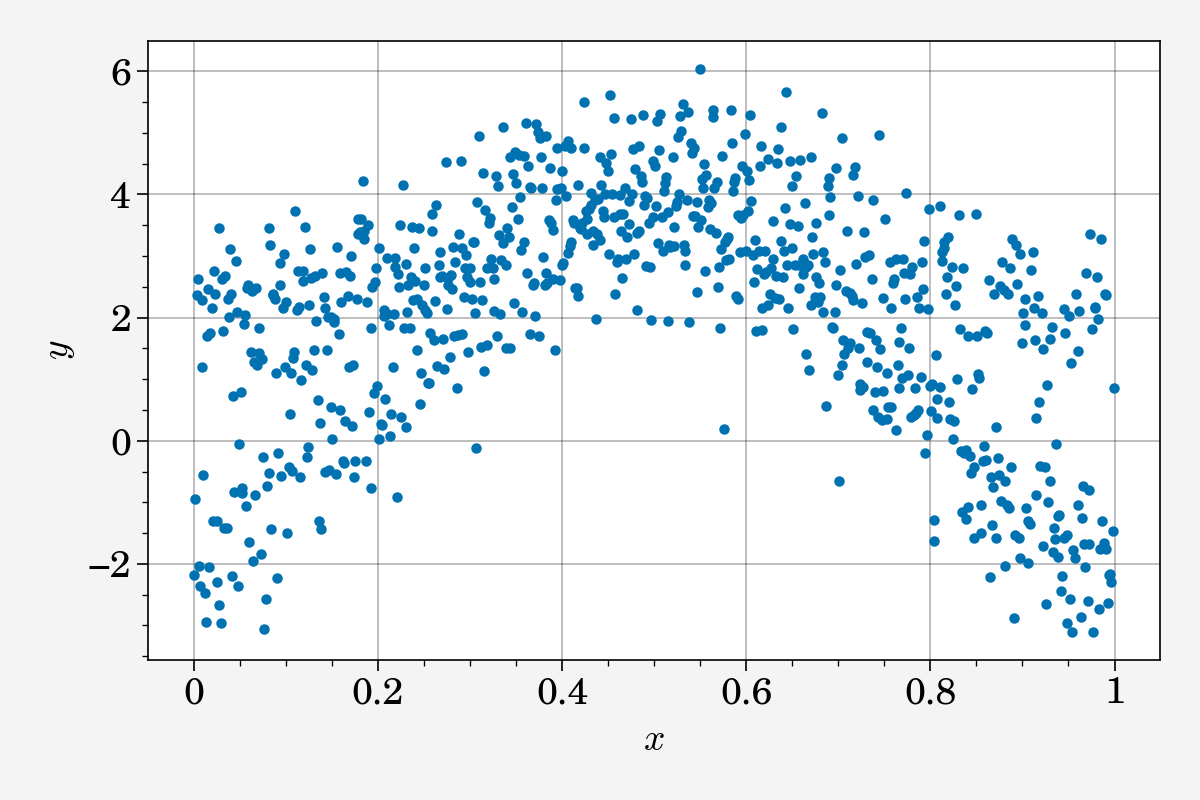

In [13]:
plt.scatter(X, y, s=10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

plt.tight_layout()
plt.show()

In [14]:
sim_name = "BE_only_N_p5_q075_1"

if not os.path.exists(f"optuna_verbose/{sim_name}"):

    PCE_result_optuna = StochasticPCE(X = X, 
                                      y = y, 
                                      dist_obj = joint_x,
                                      D = ["Normal"], 
                                      p_values = [5],
                                      q_values = [0.75, 1],
                                      scale_e_LOO = 1,
                                      sim_name = sim_name).fit_adaptively()



`BE_only_N_p5_q075_1`

best CV score: Normal, $p=5, q=1$

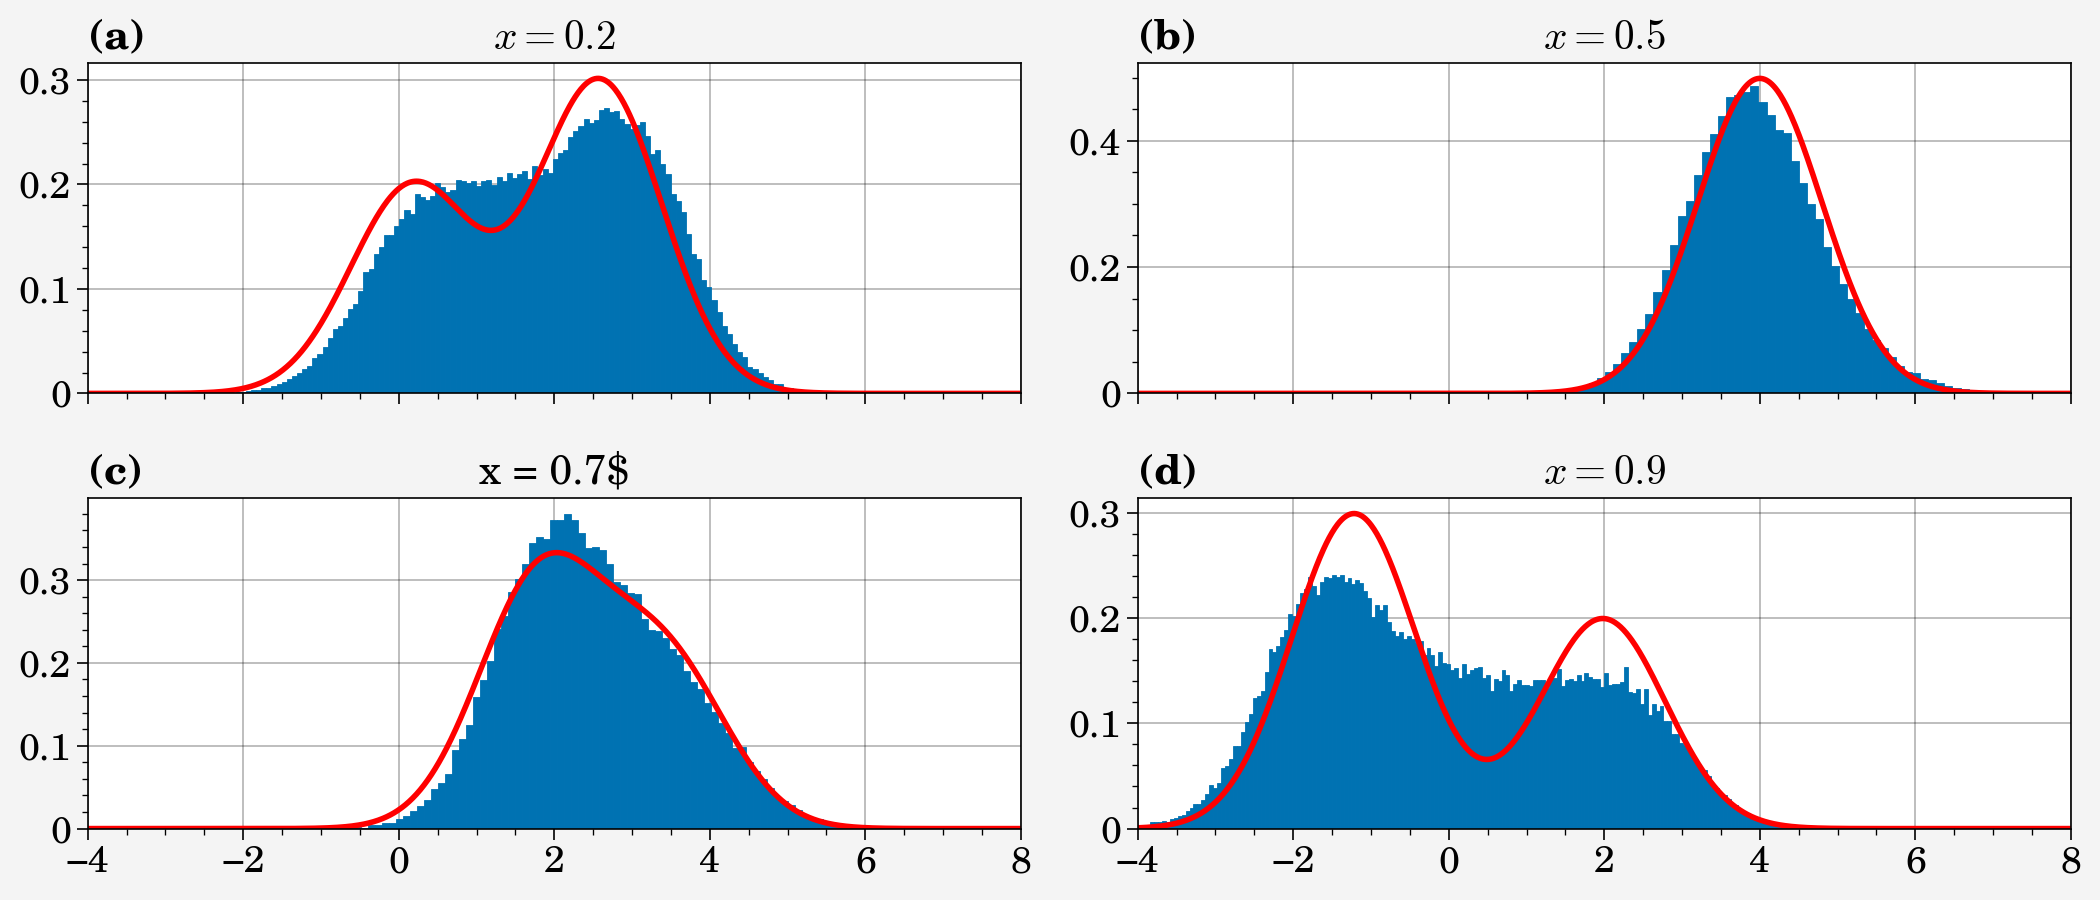

In [15]:
SPCE_results = np.load(f'optuna_verbose/BE_only_N_p5_q075_1/inter_res_D_Normal_p_5_q_1.npz', 
                      allow_pickle=True)

D     = SPCE_results['x1']
p     = SPCE_results['x2']
q     = SPCE_results['x3']
A     = SPCE_results['x4']
c_hat = SPCE_results['x5']
sigma_hat = SPCE_results['x6']
cv_score  = SPCE_results['x7']

x_samples = [[0.2], [0.5], [0.7], [0.9]]

x_sample_titles = [r"$x = 0.2$", r"$x = 0.5$", r"x = 0.7$", r"$x = 0.9$"]

fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(10.5, 4.5), sharex=True, sharey=False)

for i, x_sample in enumerate(x_samples):
    check = sample_from_cond_pdf(x = x_sample, 
                                 n_samples = 100000, 
                                 c = c_hat, 
                                 sigma = sigma_hat, 
                                 D = D, 
                                 A = A,  
                                 dist_obj = joint_x)


    y_pts = np.linspace(-4, 8, 1000)

    axs[i].plot(y_pts, mixture_gaussian_example(x_sample.pop(), y_pts), linewidth=2, color='r')
    axs[i].hist(check, bins=1000, density=True)
    
    axs[i].format(title=x_sample_titles[i])
    
    
for ax in axs:
    ax.format(abc='(a)', xlim=(-4, 8))

plt.show()

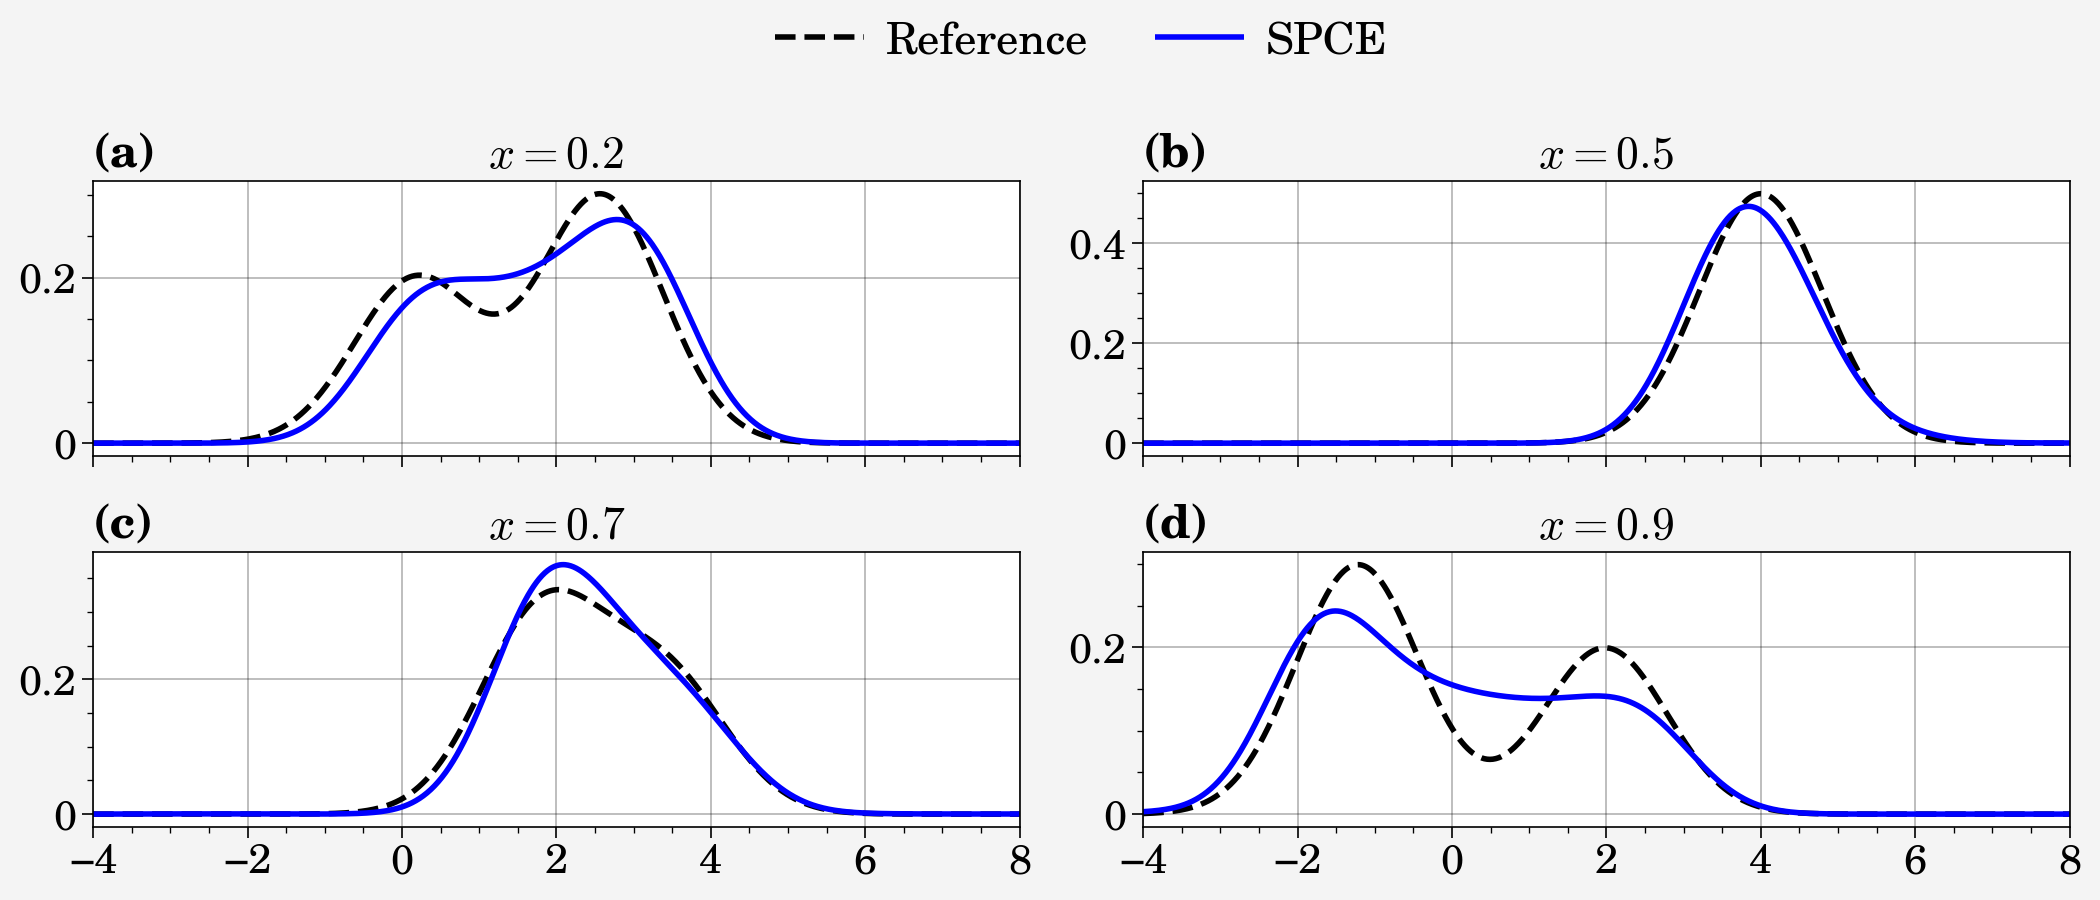

In [16]:
y_pts = np.linspace(-4, 8, 1000)

x_samples = [[0.2], [0.5], [0.7], [0.9]]

x_sample_titles = [r"$x = 0.2$", r"$x = 0.5$", r"$x = 0.7$", r"$x = 0.9$"]


fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(10.5, 4.5), sharex=True, sharey=False)

for i, x_sample in enumerate(x_samples):
    est_pdf = explicit_pdf(y_pts=y_pts, 
                           x = x_sample, 
                           c = c_hat, 
                           sigma = sigma_hat, 
                           D = D, 
                           A = A,  
                           dist_obj = joint_x,
                           NQ=150)

    axs[i].plot(y_pts, mixture_gaussian_example(x_sample.pop(), y_pts), label = "Reference", 
                linewidth=2, color='k', ls="--")
    axs[i].plot(y_pts, est_pdf, linewidth=2, color='b', label = "SPCE")
    
    axs[i].format(title=x_sample_titles[i], fontsize = 15)

fig.legend(["Reference", "SPCE"], ncols=2, frame=False, loc='t',
           fontsize = 16, bbox_to_anchor=(0.5, 0.8))
       
for ax in axs:
    ax.format(abc='(a)', xlim=(-4, 8))

plt.tight_layout()
plt.savefig("plots/SPCE_verification/BE_PDFs.pdf", bbox_inches="tight")
plt.show()